# Programming Assignment 3 - Epipolar Geometry

by Mark Jeremy G. Narag

This Programming Assignment has five (5) steps which I will discuss one by one.

### 1. Load the image pair library1 camera, library2 camera and matching points file library matches.txt.

[[460.0805   104.9175   406.3635    82.941   ]
 [382.9605   108.0555   334.3105    93.6585  ]
 [106.718    102.545    115.988    109.5505  ]
 ...
 [231.88115  103.41166  207.82166  101.60805 ]
 [384.81      78.406745 336.47062   60.910215]
 [443.79631   67.695265 392.18692   42.129562]]


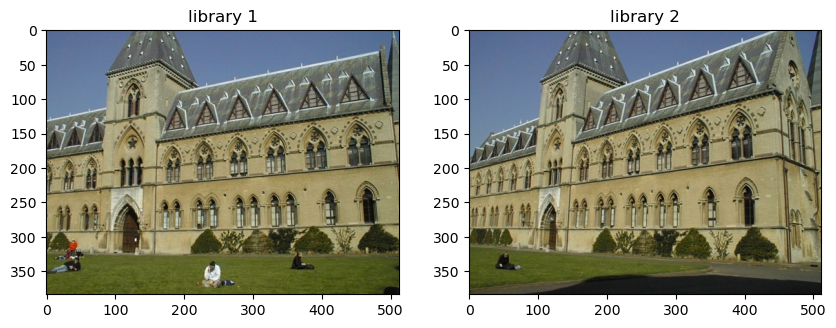

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

#I need to convert it from BGR to RGB since I will be using plt.imshow later
lib1 = cv2.cvtColor(cv2.imread('epipairs/library1.jpg'), cv2.COLOR_BGR2RGB) 
lib2 = cv2.cvtColor(cv2.imread('epipairs/library2.jpg'), cv2.COLOR_BGR2RGB)

with open('epipairs/library_matches.txt', 'r') as file:
    # Read all lines, split each line into columns, and store them in a NumPy array
    data_array = np.array([line.strip().split('\t') for line in file])
matches = np.loadtxt('epipairs/library_matches.txt')
print(matches)

plt.figure(figsize = (10,5))
plt.subplot(121), plt.imshow(lib1), plt.title('library 1')
plt.subplot(122), plt.imshow(lib2), plt.title('library 2')
plt.show()

In [2]:
#When I opened the text file, it has exponential term. Using numpy to read it will fail since it will treat is as a string
#Thus, I will instead use pandas to read the file. It is all better to work with panas
import pandas as pd

file_path = 'epipairs/library_matches.txt'
matches = pd.read_csv(file_path, sep=' ', header=None, names=['col1', 'col2', 'col3', 'col4'],skipinitialspace=True)
#Note that the separation in text file is double spaced that is why I added "skipinitialspace=True"

print(matches)

          col1        col2       col3        col4
0    460.08050  104.917500  406.36350   82.941000
1    382.96050  108.055500  334.31050   93.658500
2    106.71800  102.545000  115.98800  109.550500
3    115.66350  103.411000  123.78050  109.638000
4    367.69600  135.475000  313.52150  124.691000
..         ...         ...        ...         ...
304  348.31228   84.070730  316.48110   71.289450
305  202.03489  117.481080  193.86953  117.728310
306  231.88115  103.411660  207.82166  101.608050
307  384.81000   78.406745  336.47062   60.910215
308  443.79631   67.695265  392.18692   42.129562

[309 rows x 4 columns]


### 2. Fit a fundamental matrix to the matching points. There is no need to use RANSAC here since all the matches are correct. Report the residual, which should be the mean squared distance (in pixels) between points in the second image and the corresponding epipolar lines.

Epipolar geometry is the intrinsic projective geometry between two views and fundamental matrix $\mathbf{F}$ encapsulates this intrinsic geometry. It is a $3 \times 3$ matrix of rank 2. It is given by

$$
F = K'^{-T}[t]_{\times}RK^{-1}
$$

where $\mathbf{K}$ and $\mathbf{K'}$ are the internal calibration of the cameras and $\mathbf{R}$ is the rotation.

However, we don't know these calibration matrices. BUT, since we already have the matching points, we can actually estimate the Fundamental matrix $\mathbf{F}$ from

$$
\mathbf{x'^{T}Fx} = 0
$$

where $\mathbf{x}$ and $\mathbf{x'}$ are the image points of image 1 and image 2, respectively. We need $\mathbf{F}$ to get the epipolar lines!

Now, the matching points given in text file have four columns. It is safe to assume that the first two columns are the x and y coordinates of the first image, while the 3rd and 4th columns are for the second image. Let's store them first as x1 and x2:

In [3]:
#Note that we need to work with numpy array so we need to convert our panda dataframe back to numpy
x1 = matches[['col1', 'col2']].to_numpy() # x1 is from the 1st and 2nd column
x2 = matches[['col3', 'col4']].to_numpy() # x2 is from the 3rd and 4th column
print('first coordinate of x1 = ',x1[0])
print('first coordinate of x2 = ',x2[0])

first coordinate of x1 =  [460.0805 104.9175]
first coordinate of x2 =  [406.3635  82.941 ]


But remember that $\mathbf{x1}$ and $\mathbf{x2}$ should be in homogenous 3D coordinate. That is, the z-axis of the two vectors should be 1. We can do this by just adding 1 on the existing vector:

In [4]:
x1 = np.c_[x1, np.ones(x1.shape[0])]
x2 = np.c_[x2, np.ones(x2.shape[0])]
print('first coordinate of x1 (homogeneous 3D) = ',x1[0])
print('first coordinate of x2 (homogeneous 3D) = ',x2[0])

first coordinate of x1 (homogeneous 3D) =  [460.0805 104.9175   1.    ]
first coordinate of x2 (homogeneous 3D) =  [406.3635  82.941    1.    ]


So the challenge now is how to estimate $\mathbf{F}$ given matching points $\mathbf{x1}$ and $\mathbf{x2}$? We can do that using the EIGHT POINT ALGORITHM which was proposed by Longuet-Higgins in 1981 and extended by Hartley in 1995. Basically, we just need atleast 8 matching points to estimate the fundamental matrix but since we 309 matches, we will use all of them. The eight point algorithm is basically an SVD.


First step is to make it compact, meaning, we will write $\mathbf{x'^{T}Fx} = 0$ as this:
$$\mathbf{WF} = 0$$

Given $x1 = (u_i, v_i, 1)$ and $x2 = (u'_i, v'_i, 1)$,
$$W = \begin{bmatrix}
u_1u'_1 & v'_1u_1 & u'_1 & u'_1v_1 & v_1v'_1 & v_1 & u'_1 & v_1 & 1 \\
u_2u'_2 & v'_2u_2 & u'_2 & u'_2v_2 & v_2v'_2 & v_2 & u'_2 & v_2 & 1 \\
....\\
u_nu'_n & v'_nu_n & u'_n & u'_nv_n & v_nv'_n & v_n & u'_n & v_n & 1 \\
\end{bmatrix}
$$

$n$ is the number of matches. Note that $\mathbf{W}$ is just the Kronecker product of the two arrays where each element of x1 is multiplied by the entire matrix of x2.

However, before we build W, we need to normalize the matching points first. According to Hata and Savarese, in practice, the standard least-squares approach to the Eight-Point Algorithm is not precise. Often, the distance between a point $x_i$ and its corresponding epipolar line $l_i = Fx'$ will be very large, thus, we need to normalize it.

##### source: Kenji Hata and Silvio Savarese, CS231A Course Notes 3: Epipolar Geometry. URL: https://web.stanford.edu/class/cs231a/course_notes/03-epipolar-geometry.pdf

In [5]:
#As i mentioned, let us normalize the points first:
def normalize(points):
    centroid = np.mean(points, axis=0) #basically this is just the center of mass of the points (physics 71 hehe)
    mean_distance = np.mean(np.sqrt(np.sum((points - centroid) ** 2, axis=1))) 
    #the above is just the mean of the Euclidean distances of each point from the centroid
    
    #Now, we need to scale it to ensure na the points are not too large or small
    #lets make the mean distance equal to square root of 2
    scale = np.sqrt(2) / mean_distance
    #let;s calculate the translation vector
    #this is useful if we want to move the centroid to the origin.
    translation = -scale * centroid
    #We now create a matrix that represents the combination of scaling and translation:
    T = np.array([[scale, 0, translation[0]],
                  [0, scale, translation[1]],
                  [0, 0, 1]])
    #we normalize:
    normalized_points = np.dot(T, points.T).T
    return normalized_points, T

x1_norm, T1 = normalize(x1)
x2_norm, T2 = normalize(x2)

Now, we are ready to build the compact matrix W. We will use the `np.kron` function to compute the Kronecker product of the two arrays. 

In [6]:
W = np.zeros((len(x1), 9))
for i in range(len(x1)):
    W[i] = np.kron(x2_norm[i], x1_norm[i])
print('first row of W = ', W[0])

first row of W =  [ 2.42701512 -1.31853131  1.57486396 -1.83685448  0.99791309 -1.19191508
  1.54109509 -0.83723505  1.        ]


Let's check the first term $u_1u'_1$ = 460.0805*406.3635 = 186,959.922 which is correct!

We can now estimate $\mathbf{F}$ using Singular Value Decomposition (SVD). We can use `numpy.linalg.svd(W)` package for this where we will get U, S, and Vt which is from $W=U⋅diag(S)⋅V^T$

U: Left singular vectors. This has the same shape as W. \
S: Singular values, within each vector sorted in descending order. Size is the number of columns.\
Vt: Unitary array. This has the shape of the number of columns by itself. 

In [7]:
U, S, V = np.linalg.svd(W)
print(np.shape(U),np.shape(S), np.shape(V))

(309, 309) (9,) (9, 9)


Now, we need to extract the last row of V since the singular values are ordered in decreasing order along the diagonal of S. The last row of corresponds to the least significant singular value. Note that the fundamental matrix is defined up to a scale factor, meaning that if F is a valid fundamental matrix, then any scalar multiple λF is also a valid fundamental matrix. By considering the least significant singular value, we are essentially choosing a solution that is normalized in a way, as it is effectively saying that the least significant direction is less relevant for determining the overall structure captured by the fundamental matrix. With that being said:

In [8]:
F = V[-1].reshape(3, 3) #remember that this has a length of 9 so we need to reshape it into 3 by 3 matrix
print('F=', F)

F= [[-5.02779630e-04  6.76610364e-03  1.53562852e-03]
 [-4.11090780e-02 -4.22454574e-04  6.37653535e-01]
 [ 2.36727919e-02 -7.68655284e-01  1.63736621e-02]]


Now, let us enforce a rank-2 contraint on our $\mathbf{F}$ which implies that its third singular value should be set to zero. We can do this by setting S[2] = 0

In [9]:
U1, S1, V1 = np.linalg.svd(F) #we compute SVD again from our fundamental matrix F
S1[2] = 0 #this is to impose that the 3rd singular value should be zero since F is rank-2

Next, we need to reconstruct our final $\mathbf{F}$ using 
$$F_{final}=U'\cdot diag(S') \cdot V'^T$$

clarification: prime there is '1' in the code.

In [10]:
F_final = np.dot(U1, np.dot(np.diag(S1), V1)) #this is not yet final
#Note that we need to denormalize it:
F_final = np.dot(T2.T, np.dot(F_final, T1)) 
print('final F (rank 2) = ', F_final)

final F (rank 2) =  [[-3.66106207e-08  7.80422368e-07 -1.18097936e-04]
 [-4.73752936e-06 -4.86861294e-08  8.79648624e-03]
 [ 1.13070861e-03 -7.90017674e-03 -2.13969289e-01]]


Next step is to get the epipolar line on the second image which is just
$$\mathbf{l' = Fx}$$

In [11]:
l2 = np.dot(F_final, x1.T).T

Then computing the distances between points in the second image and the corresponding epipolar lines, then the mean. Note that the distance is computed as follows:

$$
d = \frac{|l_2 \cdot x2|}{\sqrt{l_2[0]^2 + l_2[1]^2}}
$$
note that $\sqrt{l_2[0]^2 + l_2[1]^2}$ is the L2 norm.

In [12]:
d = np.abs(np.sum(l2 * x2, axis=1)) / np.sqrt(l2[:, 0]**2 + l2[:, 1]**2)
msd = np.mean(d**2)
print('mean squared distance (residual) = ', msd)

mean squared distance (residual) =  0.0602524408936073


### 3. Now fit a fundamental matrix based on putative correspondences obtained by your code from Programming Assignment 2. Because the set of putative matches includes outliers, you will need to use RANSAC. For this part, use only the normalized fitting approach.

Just copying my code from last assignment:

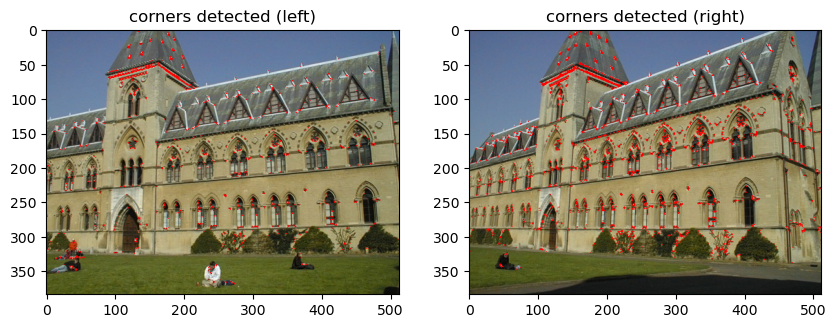

In [13]:
#----------HARRIS CORNER DETECTION----------#
gray_lib1 = cv2.cvtColor(lib1, cv2.COLOR_RGB2GRAY).astype(np.float32)
gray_lib2 = cv2.cvtColor(lib2, cv2.COLOR_RGB2GRAY).astype(np.float32)
harris_lib1 = cv2.cornerHarris(gray_lib1, blockSize=2, ksize=3, k=0.04)
harris_lib2 = cv2.cornerHarris(gray_lib2, blockSize=2, ksize=3, k=0.04)

threshold = 0.02 #ofcourse we can change this
harris_lib1[harris_lib1 < threshold * harris_lib1.max()] = 0 #anything lower than the thresh will be black
harris_lib1[harris_lib1 > threshold * harris_lib1.max()] = 255 #anything higher than the thresh will be white
harris_lib2[harris_lib2 < threshold * harris_lib2.max()] = 0
harris_lib2[harris_lib2 > threshold * harris_lib2.max()] = 255

lib1_copy = lib1
lib2_copy = lib2
lib1_copy[harris_lib1 > threshold * harris_lib1.max()] = [255,0,0] #this is RED
lib2_copy[harris_lib2 > threshold * harris_lib2.max()] = [255,0,0] 
plt.figure(figsize = (10,12))
plt.subplot(121), plt.imshow(lib1_copy), plt.title('corners detected (left)')
plt.subplot(122), plt.imshow(lib2_copy), plt.title('corners detected (right)')
plt.show()

#----------FLATTENING----------#
def flattened_patches(image,corner_coordinates):
    patch_size = 11 #we can change this but let us stick with this first
    patches = []
    coords = []
    for x, y in corner_coordinates:
        #let us calculate the coordinates for the top-left corner of the patch
        start_x = x - patch_size // 2
        start_y = y - patch_size // 2
        #then the bottom-right corner of the patch
        end_x = x + patch_size // 2
        end_y = y + patch_size // 2
        #then just to make sure that it will not go out of the image bounds
        if start_x >= 0 and start_y >= 0 and end_x < gray_lib1.shape[0] and end_y < gray_lib1.shape[1]:
            patch = image[start_x:end_x+1, start_y:end_y+1].flatten()
            z = [x,y]
            coords.append(z)
            patches.append(patch)
    coords = np.array(coords)
    return patches, coords
lib1_corner_coordinates = np.column_stack(np.where(harris_lib1 == 255))#getting the coordinates for left harris
lib2_corner_coordinates = np.column_stack(np.where(harris_lib2 == 255))#getting the coordinates for right harris
lib1_patch,lib1_corner_coordinates = flattened_patches(gray_lib1,lib1_corner_coordinates)#getting the flatted version of patches for left image
lib2_patch, lib2_corner_coordinates = flattened_patches(gray_lib2,lib2_corner_coordinates)#getting the flatted version of patches for right image

#----------COMPUTING EUCLIDEAN DISTANCES----------#
#let's create a matrix where we will store the euclidean values:
euclidean_distances = np.zeros((len(lib1_patch), len(lib2_patch))) 
for i in range(len(lib1_patch)):
    for j in range(len(lib2_patch)):
        euclidean_distances[i, j] = np.linalg.norm(lib1_patch[i] - lib2_patch[j])

indices = np.argsort(euclidean_distances, axis=None)[0:500]
indices_2d = np.unravel_index(indices, euclidean_distances.shape)
selected_descriptor_pairs = list(zip(indices_2d[0], indices_2d[1]))

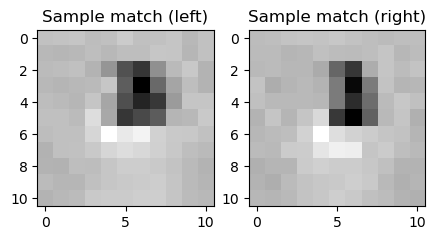

In [14]:
#let us check if they are really a match
#we can either unflatten the descriptor or extract the patch from the coordinate:
plt.figure(figsize = (5,10))
height = 11
width = 11
i=0 #change this for other patches
l = selected_descriptor_pairs[i][0]
r = selected_descriptor_pairs[i][1]
l_coor = lib1_corner_coordinates[selected_descriptor_pairs[i][0]]
r_coor = lib2_corner_coordinates[selected_descriptor_pairs[i][1]]
imagel = lib1_patch[l].reshape((height, width))
imager = lib2_patch[r].reshape((height, width))

def check_patches(image,patch_size,x,y): 
    start_x = x - patch_size // 2 
    start_y = y - patch_size // 2
    end_x = x + patch_size // 2
    end_y = y + patch_size // 2
    patch = image[start_x:end_x+1, start_y:end_y+1]
    return patch
plt.subplot(121),plt.imshow(check_patches(gray_lib1,11,l_coor[0],l_coor[1]), cmap='gray')
plt.title('Sample match (left)')
plt.subplot(122),plt.imshow(check_patches(gray_lib2,11,r_coor[0],r_coor[1]), cmap='gray')
plt.title('Sample match (right)')
plt.show()

In [15]:
#Getting the matches:
x1_ransac = []
x2_ransac = []
for i in range(0, len(selected_descriptor_pairs)):
    x1_ransac.append(lib1_corner_coordinates[selected_descriptor_pairs[i][0]])
    x2_ransac.append(lib2_corner_coordinates[selected_descriptor_pairs[i][1]])
x1_ransac = np.array(x1_ransac)
x2_ransac = np.array(x2_ransac)
x1_ransac[:, [0, 1]] = x1_ransac[:, [1, 0]]#magkabaliktad kasi si x and y here
x2_ransac[:, [0, 1]] = x2_ransac[:, [1, 0]]
#adding one on the z axis
x1_ransac = np.c_[x1_ransac, np.ones(x1_ransac.shape[0])]
x2_ransac = np.c_[x2_ransac, np.ones(x2_ransac.shape[0])]
#normalizing it
x1_norm_ransac, T1_ransac = normalize(x1_ransac)
x2_norm_ransac, T2_ransac = normalize(x2_ransac)


In [16]:
confidence=0.99
max_iters=1000
threshold=0.001

# Use RANSAC to robustly estimate the fundamental matrix
F_ransac, mask_ransac = cv2.findFundamentalMat(x1_norm_ransac, x2_norm_ransac, cv2.FM_RANSAC, threshold, confidence)
F1_ransac = np.dot(T2_ransac.T, np.dot(F_ransac, T1_ransac))  #denormalize
print('F= ', F1_ransac)
print('number of inliers =',np.sum(mask_ransac))

F=  [[ 1.30464437e-06 -3.75146025e-05 -3.99131760e-04]
 [ 8.81924917e-05 -2.43966292e-05 -2.67799716e-01]
 [-8.75145645e-03  2.57815729e-01  2.08568083e+00]]
number of inliers = 56


### 4. Load the camera matrices for the two images (they are stored as 3x4 matrices in the files library1_camera.txt and library2_camera.txt). Find the centers of the two cameras. Use linear least squares to triangulate the position of each matching pair of points given the two cameras. Display the two camera centers and scene matches in 3D. Also compute the residuals between the observed 2D points and the projected 3D points in the two images.

The $3 \times 4$ camera projection matrix takes the form:
$$ P=K[R∣t]$$
where $K$ is the 3x3 intrinsic parameters of the camera and $[R∣t]$ is the 3x4 extrinsic parameters (rotation and translation), we can get the center of the camera $C$ by taking the product of the inverse of the intrinsic matrix $K$ and the camera projection matrix $P$:

$$M =K^{−1} \cdot P$$

Just like what we did in getting the fundamental matrix, the camera center $C$ can then be obtained from the right singular vector of $M$ which corresponds to the smallest singular value.

Note that we still need to decompose $P$. We will use this numpy function to decompose it:
`numpy.linalg.qr` -> computes the decomposition of our $P$ matrix. It decomposes $P$ into the product of an orthogonal matrix $K$ and an upper triangular matrix $Rt$.

In [17]:
#let's create a function for camera center since we will be computing two centers for the two cameras:
def camera_center(P):
    #we need to decompose P into K and [R|t]:
    K, RT = np.linalg.qr(P[:, :3]) #see my discussion above regarding np.linalg.qr
    #then we get the matrix product of K inverse and P:
    M = np.dot(np.linalg.inv(K), P)
    #then we perform SVD on M:
    _, _, Vt = np.linalg.svd(M) #I just put _,_ on U and S since we dont need it. Sayang memory
    #lastly, as I mentioned, we extract the camera center from the right singular vector
    C = Vt[-1, :3] / Vt[-1, 3]
    #note that Vt[-1, :3] extracts the first three elements of the last row. 
    #these three elements are the coordinates of the camera center in homogeneous coordinates.
    #and Vt[-1, 3] is the fourth element of the last row and is associated with the homogeneous coordinate
    #we divide Vt[-1, :3] by it to get the cartesian coordinates.
    return C

In [18]:
#Finally, we do computation
#read the txt file first
lib1_cam_p1 = np.loadtxt('epipairs/library1_camera.txt')
lib2_cam_p2 = np.loadtxt('epipairs/library2_camera.txt')
#get the centers!
lib1_cam_center = camera_center(lib1_cam_p1)
lib2_cam_center = camera_center(lib2_cam_p2)
print('camera center of library 1 =',lib1_cam_center)
print('camera center of library 2 =',lib2_cam_center)

camera center of library 1 = [  7.28863053 -21.52118112  17.73503585]
camera center of library 2 = [  6.89405488 -15.39232716  23.41498687]


Next step is to use linear least squares to triangulate the position of each matching pair of points given the two cameras. For linear triangulation, remember that given the camera projection $P$, we can relate 2D and 3D space given:
$$\mathbf{x = PX}$$
where the left side is the 2D position and the right side is the 3D position of a point. Based from our class slides, for the first camera:
$$P = 
\begin{bmatrix}
p_{11}&p_{12}&p_{13}&p_{14}\\
p_{21}&p_{22}&p_{23}&p_{24}\\
p_{31}&p_{32}&p_{33}&p_{34}\\
\end{bmatrix}
=
\begin{bmatrix}
p^{1T}\\
p^{2T}\\
p^{3T}\\
\end{bmatrix}
$$
Following the slides discussion, we can eliminate unknown scale in $\lambda x = PX$ by forming a cross product $x \times (PX) = 0$:
$$
x(\mathbf{p}^{3T}\mathbf{X}) - (\mathbf{p}^{1T}\mathbf{X}) = 0\\
y(\mathbf{p}^{3T}\mathbf{X}) - (\mathbf{p}^{2T}\mathbf{X}) = 0\\
x(\mathbf{p}^{2T}\mathbf{X}) - y(\mathbf{p}^{1T}\mathbf{X}) = 0\\
$$
rearranging as the first two columns only:
$$
\begin{bmatrix}
x(\mathbf{p}^{3T}) - (\mathbf{p}^{1T})\\
y(\mathbf{p}^{3T}) - (\mathbf{p}^{2T})\\
\end{bmatrix}\mathbf{X}= 0
$$
Doing the same for the second camera and making it $\mathbf{AX = 0}$, we have:
$$
A = 
\begin{bmatrix}
x(\mathbf{p}^{3T}) - (\mathbf{p}^{1T})\\
y(\mathbf{p}^{3T}) - (\mathbf{p}^{2T})\\
x'(\mathbf{p'}^{3T}) - (\mathbf{p'}^{1T})\\
y'(\mathbf{p'}^{3T}) - (\mathbf{p'}^{2T})\\
\end{bmatrix}
$$

From this point onwards, we can get $\mathbf{X}$ using SVD!!

#### source: Stereo Correspondence (Lecture 7) slides by Dr. Prospero Naval.

In [19]:
#remember that the above equation gets the x for each point in the matches
N = matches.shape[0] #how many matches do we have?
#then let's create an empty array of size N by 3 (since 3D coordinates). We will store our calculated values here:
triangulation = np.zeros((N, 3)) 
for i in range(N):
    #let us extract each u,v,_ coordinate for each of our matches. I put _ since we don't need it and that is just 1
    u1, v1, _ = x1[i] #remember that x1 contains the matches of first image
    u2, v2, _ = x2[i] #x2 for the second image
    
    A = np.zeros((4, 4)) #creating A matrix for storing
    A[0, :] = u1*lib1_cam_p1[2] -  lib1_cam_p1[0] #this is x(p^3T) - (p^1T)
    A[1, :] = v1*lib1_cam_p1[2] -  lib1_cam_p1[1] #this is y(p^3T) - (p^2T)
    A[2, :] = u2*lib2_cam_p2[2] -  lib2_cam_p2[0] #this is x'(p^3T) - (p^1T)
    A[3, :] = v2*lib2_cam_p2[2] -  lib2_cam_p2[1] #this is y'(p^3T) - (p^2T)
    
    #we can now get solution x from Ax=0 using SVD:
    _, _, Vt = np.linalg.svd(A) #I dont need U and S
    triangulation[i, :] = Vt[-1, :3] / Vt[-1, 3] #similar explanation kanina sa camera center

#print(triangulation)

Okay, then we display the two camera centers and scene matches in 3D:

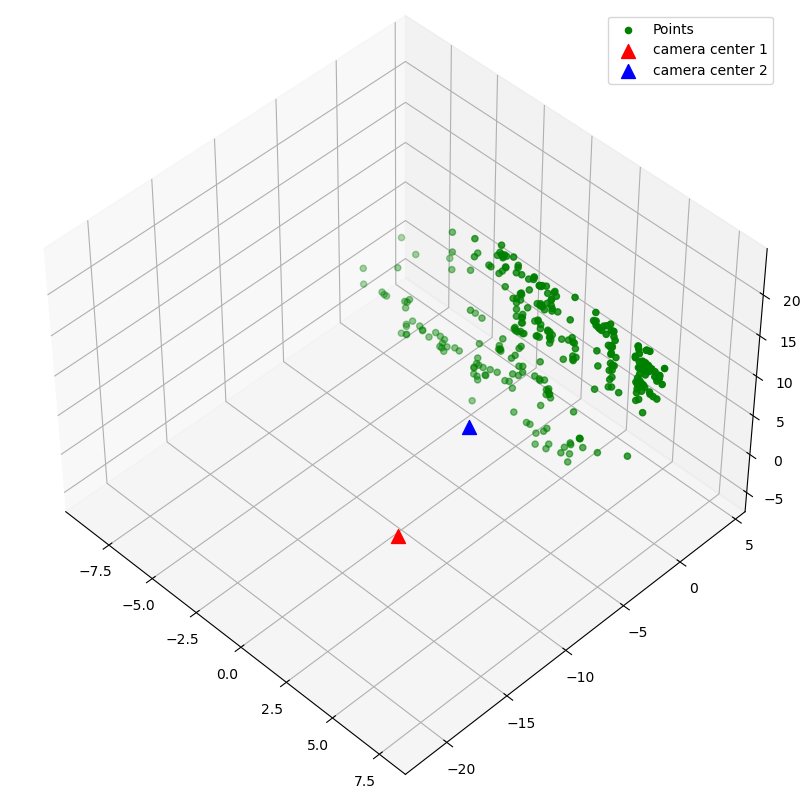

In [20]:
from mpl_toolkits.mplot3d import Axes3D
# visualization of library point cloud
camera_centers_library = np.vstack((lib1_cam_center, lib2_cam_center))
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(triangulation[:, 0], triangulation[:, 1], triangulation[:, 2], c='g', label='Points')
ax.scatter(camera_centers_library[0, 0], camera_centers_library[0, 1], 
           camera_centers_library[0, 2], c='r', s=100, 
           marker='^', label='camera center 1')
ax.scatter(camera_centers_library[1, 0], camera_centers_library[1, 1], 
           camera_centers_library[1, 2], c='b', s=100, 
           marker='^', label='camera center 2')
ax.view_init(azim=-45, elev=45)
ax.legend(loc='best')

Next is to compute the residuals between the observed 2D points and the projected 3D points in the two images.

In [21]:
N = len(triangulation)
triangulation_3d = np.hstack((triangulation, np.ones((N, 1)))) #just to add value 1 on the 4th column
#Remember that we need to project the triangulated 3D points back into the image planes using our camera projection matrices:
projected1 = np.dot(lib1_cam_p1, triangulation_3d.T).T #this is just the dot product of triangulation and camera projection
projected2 = np.dot(lib2_cam_p2, triangulation_3d.T).T #remember that projection is cosine and cosine is dot product!
#Then normalize:
#note that we only want the difference of u,v and x,y so we just need the first two columns
u1 = projected1[:, 0] / projected1[:, 2]
v1 = projected1[:, 1] / projected1[:, 2]
u2 = projected2[:, 0] / projected2[:, 2]
v2 = projected2[:, 1] / projected2[:, 2]
#since we want to get the perpendicular distance from the point to the epipolar line, we can use np.hypot
#np.hypot(x,y) outputs the square root of x^2 and y^2. Which is our equation for distance:
#d^2 = (u1-x1)^2 + (v1-x2)^2 where u1,v1 is the coordinate of one point and x1,x2 is the coordinate of another point
residual1 = np.sum(np.hypot(u1-x1[:, 0], v1-x1[:, 1])) 
residual2 = np.sum(np.hypot(u2-x2[:, 0], v2-x2[:, 1]))
print('2D mean residual for lib1: ', np.mean(residual1))
print('2D mean residual for lib2: ', np.mean(residual2))

2D mean residual for lib1:  24.662071196869743
2D mean residual for lib2:  28.649537735259848


### 5. Apply triangulation to inlier matches that you obtained in step 3 above.

I shouldve wrote the triangulation as a function but that's fine. I will just copy my code from above:

In [22]:
#so first is to just get the inlier matches from mask_ransac:
inliers_1 = []
inliers_2 = []
for i in range(0,500):
    if mask_ransac[i] ==1:
        inliers_1.append(x1_ransac[i])
        inliers_2.append(x2_ransac[i])
inliers_1 = np.array(inliers_1)
inliers_2 = np.array(inliers_2)
print('# of inliers = ', len(inliers_1))

# of inliers =  56


In [23]:
#remember that the above equation gets the x for each point in the matches
N = len(inliers_1) #how many matches do we have?
#then let's create an empty array of size N by 3 (since 3D coordinates). We will store our calculated values here:
triangulation_ransac = np.zeros((N, 3)) 
for i in range(N):
    #let us extract each u,v,_ coordinate for each of our matches. I put _ since we don't need it and that is just 1
    u1, v1, _ = inliers_1[i] #remember that x1 contains the matches of first image
    u2, v2, _ = inliers_2[i] #x2 for the second image
    
    A_ransac = np.zeros((4, 4)) #creating A matrix for storing
    A_ransac[0, :] = u1*lib1_cam_p1[2] -  lib1_cam_p1[0] #this is x(p^3T) - (p^1T)
    A_ransac[1, :] = v1*lib1_cam_p1[2] -  lib1_cam_p1[1] #this is y(p^3T) - (p^2T)
    A_ransac[2, :] = u2*lib2_cam_p2[2] -  lib2_cam_p2[0] #this is x'(p^3T) - (p^1T)
    A_ransac[3, :] = v2*lib2_cam_p2[2] -  lib2_cam_p2[1] #this is y'(p^3T) - (p^2T)
    
    #we can now get solution x from Ax=0 using SVD:
    _, _, Vt_ransac = np.linalg.svd(A_ransac) #I dont need U and S
    triangulation_ransac[i, :] = Vt_ransac[-1, :3] / Vt_ransac[-1, 3] #similar explanation kanina sa camera center
#print(triangulation_ransac)

In [24]:
N = len(triangulation_ransac)
triangulation_3d_ransac = np.hstack((triangulation_ransac, np.ones((N, 1)))) #just to add value 1 on the 4th column
#Remember that we need to project the triangulated 3D points back into the image planes using our camera projection matrices:
projected1_ransac = np.dot(lib1_cam_p1, triangulation_3d_ransac.T).T #this is just the dot product of triangulation and camera projection
projected2_ransac = np.dot(lib2_cam_p2, triangulation_3d_ransac.T).T #remember that projection is cosine and cosine is dot product!
#Then normalize:
#note that we only want the difference of u,v and x,y so we just need the first two columns
u1_ransac = projected1_ransac[:, 0] / projected1_ransac[:, 2]
v1_ransac = projected1_ransac[:, 1] / projected1_ransac[:, 2]
u2_ransac = projected2_ransac[:, 0] / projected2_ransac[:, 2]
v2_ransac = projected2_ransac[:, 1] / projected2_ransac[:, 2]
#since we want to get the perpendicular distance from the point to the epipolar line, we can use np.hypot
#np.hypot(x,y) outputs the square root of x^2 and y^2. Which is our equation for distance:
#d^2 = (u1-x1)^2 + (v1-x2)^2 where u1,v1 is the coordinate of one point and x1,x2 is the coordinate of another point
residual1_ransac = np.sum(np.hypot(u1_ransac-inliers_1[:, 0], v1_ransac-inliers_1[:, 1])) 
residual2_ransac = np.sum(np.hypot(u2_ransac-inliers_2[:, 0], v2_ransac-inliers_2[:, 1]))
print('2D mean residual for lib1: ', np.mean(residual1_ransac))
print('2D mean residual for lib2: ', np.mean(residual2_ransac))

2D mean residual for lib1:  64.65074544781541
2D mean residual for lib2:  66.33916507767438


We got higher residual here than if we use the given matches. Thus, I don't recommend this approach.